Initial analysis on progenitors. Investigated the feature landscape, correlations of controls and deletions, and the effect of removing outliers/certain subsets of the data. Clusters, PCA, and features differentiating controls from deletions. 

Conclusion: It's not clear from initial analysis we can seperate controls and deletions, so different methods should be tried. 

In [1]:
import os
import pandas as pd
import numpy as np
import zipfile
import seaborn as sns 

import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
import matplotlib.patches as mpatches

from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from collections import Counter

from cytominer_eval import evaluate
from cytominer_eval.operations import grit
from pycytominer.cyto_utils import infer_cp_features, check_correlation_method 
# from pycytominermodz

# Functions

In [2]:
def load_data(path):
    """
    Loads the csv or csv.gz file into a pandas df, providing unique ID.
    """
    df = pd.read_csv(path)
    
    # Seperate data and metadata
    metadata_cols = [i for i in df.columns if 'Metadata' in i]
    metadata = df[metadata_cols]
    data_cols = [i for i in df.columns if i not in metadata_cols]
    
    # Remove exclude features from the data df
    data_cols = [x for x in data_cols if x.find('Costes')<0 if x.find('Manders')<0 if x.find('RWC')<0 
            if x.find('Parent')<0 if x.find('Object_Number')<0 if x.find('ObjectNumber')<0]
    data = df[data_cols]
    
    # Use metadata to create the index
    metadata_df = metadata.copy()
    data_df = data.copy()
    metadata_df['my_id'] = metadata['Metadata_line_source'] + '_' + metadata['Metadata_line_condition'] + '_' + \
        metadata['Metadata_line_ID'].astype(str) + '_' + metadata['Metadata_well_position']
    data_df['my_id'] = metadata_df['my_id']
    data_df.set_index('my_id', inplace=True)
    print('df shape: {}'.format(data_df.shape))
    
#     Remove the extraneous 'control' or 'deletion' for the isogenic perturbs, to keep naming consistency.
    new_idx = data_df.index.tolist()
    new_idx = [i.split('_')[0]+'_'+ i.split('_')[1]+'_'+ i.split('_')[3]+'_' +i.split('_')[4] \
               if 'genic' in i else i for i in new_idx]
    
    data_df.index = new_idx
    return data_df

def unstack_formatted_matrix(df, method='spearman', double=False):
    """
    df: a matrix which was the result of get_formatted_matrix
    double: whether to replicate the df and append, with id1 and id2 reversed. That way, all perturbs are represented in
        each id column, making finding non-group correlations easier
    returns: unstacked version of the matrix
    """
    
    # Unstacks the df and gets pairwise correlations for every perturbation instance
    unstack_agg_features_all = df.T.copy()
    unstack_agg_features_all = unstack_agg_features_all.corr(method=method)
    unstack_agg_features_all_tophalf = unstack_agg_features_all.where(np.triu(np.ones(unstack_agg_features_all.shape)).astype(np.bool))

    unstack_agg_all = unstack_agg_features_all_tophalf.unstack().reset_index()
    unstack_corrs_agg = unstack_agg_all.rename(columns={"level_0": "id1", "level_1": "id2", 0: "correlation"})
    # At this point, should be (384+383+...+3+2+1) = 73920 rows
    unstack_corrs_agg = unstack_corrs_agg[~unstack_corrs_agg['correlation'].isna()]
     
    # Replicate and append the dataframe, if double is True, so that each perturb is present in both cols. 
    # Should have 73920*2 cols.
    if double:
        repl = unstack_corrs_agg.copy()
        temp_id1 = repl['id1'].tolist()
        temp_id2 = repl['id2'].tolist()
        repl['id1'] = temp_id2
        repl['id2'] = temp_id1
        unstack_corrs_agg = unstack_corrs_agg.append(repl)

    # Remove correlations where id1 == id2 (same well), should have 73536(*2) rows
    unstack_corrs_agg = unstack_corrs_agg[unstack_corrs_agg['id1'] != unstack_corrs_agg['id2']]
    unstack_corrs_agg.reset_index(inplace=True, drop=True)     
    
    # Add columns to label unique perturbs
    unstack_corrs_agg['perturb1'] = unstack_corrs_agg['id1'].str.split('_').map(lambda x: x[0] + '_' + x[1])
    unstack_corrs_agg['perturb2'] = unstack_corrs_agg['id2'].str.split('_').map(lambda x: x[0] + '_' + x[1])
    unstack_corrs_agg['cell_line1'] = unstack_corrs_agg['id1'].str.split('_').map(lambda x: x[0] + '_' + x[1] + '_' + x[2])
    unstack_corrs_agg['cell_line2'] = unstack_corrs_agg['id2'].str.split('_').map(lambda x: x[0] + '_' + x[1] + '_' + x[2])
    return unstack_corrs_agg 

In [3]:
def hierarchical_cluster(df, threshold, show=False):
    """
    Returns df of cluster features
    """
    threshold=threshold
    Z1 = linkage(df, 'ward')
    flat_linkage1 = fcluster(Z1, t=threshold, criterion='distance')
    cluster_features1 = id_to_cluster(flat_linkage1, df)
    
    if show:
        plt.figure(figsize=(12, df.shape[0]/4))
        plt.axvline(x=threshold)
        label = [str(i) + ' ' + j for i, j in zip(flat_linkage1.tolist(), df.index.tolist())]
        plt.title('Clusters based on cell profiler features')
        dend1 = dendrogram(Z1, color_threshold=threshold, orientation='left', leaf_font_size=10, labels=label)
    return cluster_features1

def id_to_cluster(linkage_data, agg_features_df):
    """
    linkage_data: array of cluster numbers
    agg_features_df: df of aggregated features to merge, index must match order of linkage_data
    Returns a df with aggregated cp data and cluster number for each id
    """
    # Get cluster number with the aggregated feature data
    clusters_hierarchal_df = pd.DataFrame(data=linkage_data, index=agg_features_df.index)
    clusters_hierarchal_df.rename(columns={0:'cluster_num'}, inplace=True)
    clusters_hierarchal_df = clusters_hierarchal_df.merge(agg_features_df, how='left', left_index=True, right_index=True)

    # Get the cell profiler features by cluster
    cp_features_by_cluster = clusters_hierarchal_df.groupby(by='cluster_num').mean()
    
    return clusters_hierarchal_df

In [4]:
def ttest_2_df(df1, df2, alpha=0.05, reject_only=True):
    """
    Inputs are 2 dataframes with the same column features. Returns FDR adjusted p-values for each feature.
    """
#     assert df1.columns == df2.columns
    z_score, pvals = ttest_ind(df1.values, df2.values, axis=0)
    p_df = pd.DataFrame(pvals, index = df1.columns)
    p_df = p_df.rename(columns={0: 'pval'}) # unadjusted p values
    
    # Remove first row, which is just a ttest on the column number
    p_df =  p_df.iloc[1:]
    
    # Get corrected p-values
    q_df = p_df
    q_df['adj_p_value'] = multipletests(p_df['pval'].values, alpha=alpha, method='fdr_bh')[1]
    q_df['reject_null'] = multipletests(p_df['pval'].values, alpha=alpha, method='fdr_bh')[0]
    
    if reject_only:
        q_df = q_df[q_df['reject_null'] == True]
    
    return q_df

# Feature set selection

In [5]:
from pathlib import Path
path = os.getcwd()
base_dir = str(Path(path).parent)

switch_isogenic_labels = True

#FS data
data_by_well = pd.read_csv(base_dir + '/3.analysis/feature_sets/Progenitors/0714_stdev_corr_fs.csv', index_col=0)
data_by_well_orig = data_by_well.copy()

exclude = ['5', '6', '33', '12', '16']
try:
    idx = [i for i in data_by_well.index.tolist() if i.split('_')[2] not in exclude] # Exclude patient number
    data_by_well = data_by_well[data_by_well.index.isin(idx)]
except: pass



print ('shape: {}'.format(data_by_well.shape))

shape: (344, 508)


In [6]:
labels = data_by_well.index.tolist()
if switch_isogenic_labels:
    for i in range(len(labels)):
        if 'isogenic_deletion' in labels[i]:
            labels[i] = labels[i].replace('isogenic_deletion', 'temp')
    for i in range(len(labels)):
        if 'isogenic_control' in labels[i]:
            labels[i] = labels[i].replace('isogenic_control', 'isogenic_deletion')            
        if 'temp' in labels[i]:
            labels[i] = labels[i].replace('temp', 'isogenic_control')                    
data_by_well.index = labels

In [7]:
data_by_well_human = data_by_well[data_by_well.index.str.contains('human')]
data_by_well_iso = data_by_well[data_by_well.index.str.contains('isogenic')]

In [8]:
# data_by_well[data_by_well['Cells_AreaShape_Area']]
data_by_well

,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_EulerNumber,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_MaximumRadius,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_1_1,...,Nuclei_Intensity_StdIntensityEdge_RNA,Cells_RadialDistribution_FracAtD_RNA_1of4,Cells_RadialDistribution_FracAtD_RNA_4of4,Cells_RadialDistribution_RadialCV_RNA_1of4,Cytoplasm_RadialDistribution_FracAtD_RNA_1of4,Cytoplasm_RadialDistribution_FracAtD_RNA_3of4,Cytoplasm_RadialDistribution_FracAtD_RNA_4of4,Cytoplasm_RadialDistribution_MeanFrac_RNA_1of4,Cytoplasm_RadialDistribution_MeanFrac_RNA_4of4,Nuclei_RadialDistribution_RadialCV_RNA_1of4
human_control_1_A01,0.031558,-0.083367,0.664552,0.391890,0.378463,-0.780011,-0.920009,0.407545,0.216914,-0.076005,...,-0.476490,-0.356531,0.172471,0.942807,-0.170803,-0.128707,0.161207,0.595555,-0.760697,1.448303
human_control_1_A02,-0.054664,-0.227870,-0.182981,0.057832,-0.104090,-0.077548,-0.245233,0.146814,0.059290,0.047741,...,-0.976950,-0.528343,0.536886,0.372891,-0.117456,0.068131,0.001234,-0.175402,-0.043803,1.253137
human_deletion_30_A03,-0.161378,-0.030312,-0.608366,-0.155454,-0.328369,0.346617,0.120644,-0.316808,-0.008014,0.010128,...,-1.289001,-0.698288,0.864126,-0.446245,0.236307,0.486508,-0.433891,-0.650312,0.447906,0.192676
human_deletion_30_A04,-0.141797,-0.179424,-0.555260,-0.092694,-0.218886,0.322870,0.137112,-0.238189,0.140455,0.203817,...,-0.856017,-0.648982,0.789821,-0.199692,0.213652,0.362615,-0.335247,-0.465695,0.201889,0.475661
human_control_9_A05,-0.069913,0.521924,1.036712,0.399706,-0.082652,-0.907102,-0.741057,-0.005502,-0.540924,0.277164,...,1.140715,-0.010694,-0.111528,0.925415,0.400532,0.332637,-0.377230,0.982143,-0.921211,0.697296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
human_control_13_P20,0.016831,0.019864,-0.263138,0.072305,-1.013906,0.055551,-0.241643,0.201379,0.395312,-0.012498,...,-0.734770,-0.628921,0.722488,0.233743,0.424642,0.684446,-0.626861,-0.398738,0.132872,-0.000707
human_deletion_35_P21,-0.006812,0.010482,-0.633877,0.010154,-0.197756,0.454381,0.406647,-0.342205,-0.395438,0.093383,...,-1.187687,-0.691763,0.808472,-1.920600,0.041552,0.537426,-0.392268,-1.262896,1.404788,-2.264041
human_deletion_35_P22,-0.082822,0.274600,-0.706962,-0.052511,0.019505,0.503391,0.559702,-0.383987,-0.031568,0.246442,...,-1.112048,-0.540511,0.573411,-1.930269,-0.049885,0.493428,-0.318289,-1.226352,1.376424,-2.319311
human_control_22_P23,-0.158956,0.361959,-0.394386,0.093896,0.132013,0.127585,0.194439,-0.267188,0.250969,0.279007,...,-0.447874,-0.249812,0.189123,-0.834674,0.245688,0.457528,-0.400628,-0.686206,0.829092,-1.135828


# Feature Landscape

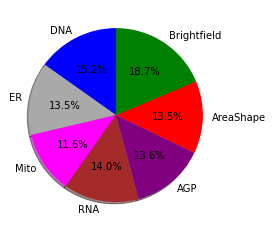

[88, 78, 67, 81, 79, 78, 108] 579


In [9]:
# Features by image channel
all_features = data_by_well.columns.tolist()
dna_ch = [i for i in all_features if 'DNA' in i[-20:]]
er_ch = [i for i in all_features if 'ER' in i[-20:]]
mito_ch = [i for i in all_features if 'Mito' in i[-20:]]
rna_ch = [i for i in all_features if 'RNA' in i[-20:]]
agp_ch = [i for i in all_features if 'AGP' in i[-20:]]
areashape = [i for i in all_features if 'AreaShape' in i]
brightfield = [i for i in all_features if 'Brightfield' in i]
labels = ['DNA', 'ER', 'Mito', 'RNA', 'AGP', 'AreaShape', 'Brightfield']
sizes = [len(dna_ch), len(er_ch), len(mito_ch), len(rna_ch), len(agp_ch), len(areashape), len(brightfield)]
fig1, ax1 = plt.subplots()
colors = ['b', 'darkgrey', 'magenta', 'brown', 'purple', 'r', 'g', 'orange']
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors,
        shadow=True, startangle=90)
plt.show()

print(sizes,sum(sizes))

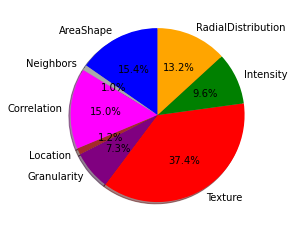

[78, 5, 76, 6, 37, 190, 49, 67] 508


In [10]:
# Features by feature type
all_features = data_by_well.columns.tolist()
all_feature_types = [i.split('_')[1] for i in all_features]
all_feature_types = Counter(all_feature_types)
labels = []
sizes = []

fig1, ax1 = plt.subplots()
for x,y in all_feature_types.items():
    labels.append(x)
    sizes.append(y)
colors = ['b', 'darkgrey', 'magenta', 'brown', 'purple', 'r', 'g', 'orange']
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors,
        shadow=True, startangle=90)
plt.show()
print(sizes,sum(sizes))

In [11]:
len([i for i in data_by_well.columns.tolist() if 'Texture' in i])

190

# Correlations

<ipython-input-12-756bd5acccd6>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90)


0.7319046189271977


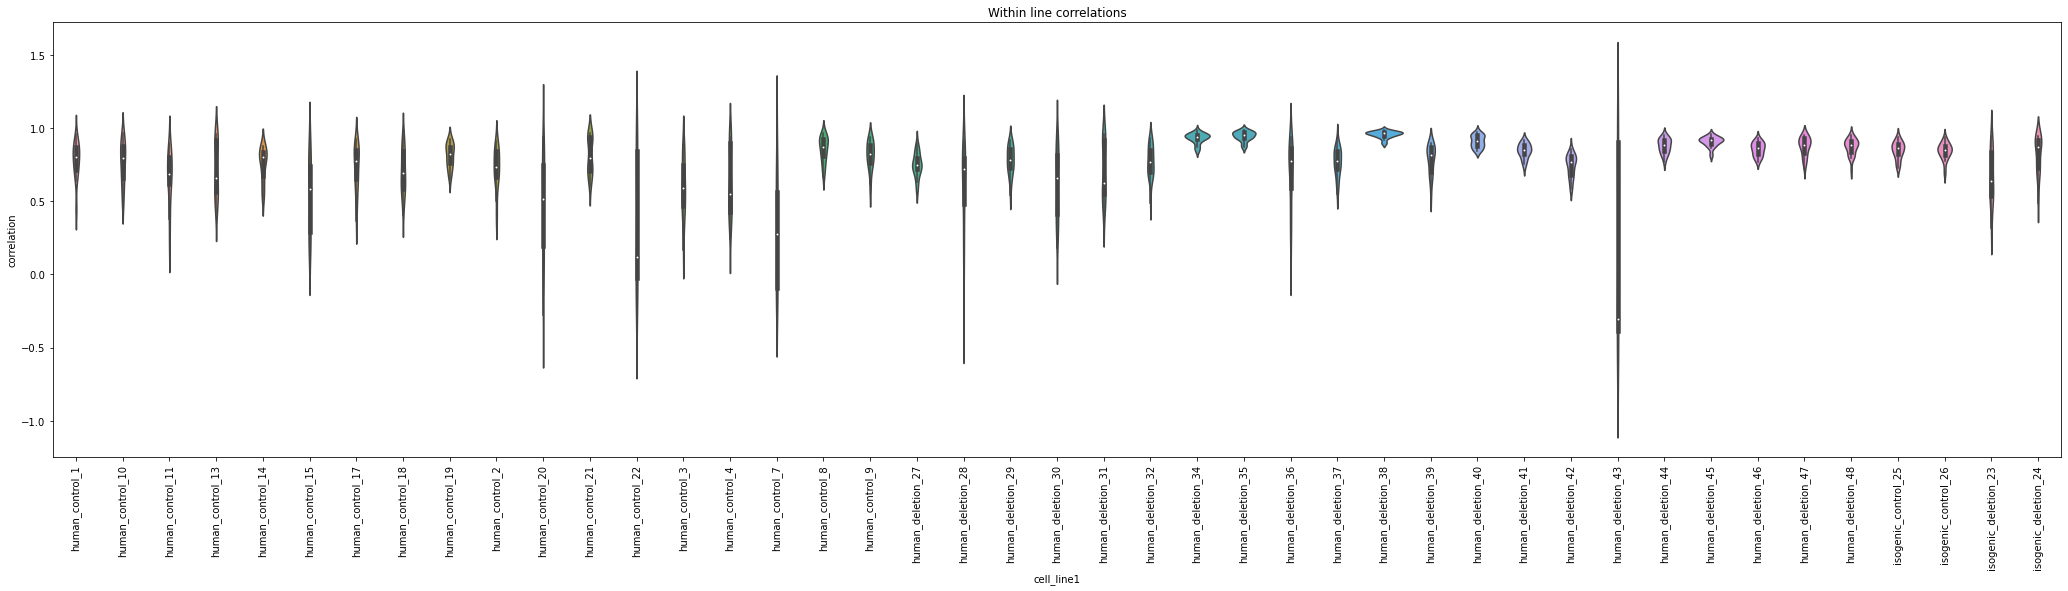

In [12]:
corrs = unstack_formatted_matrix(data_by_well)

# Get correlations within each cell line (8 replicates per)
corrs_within_line = corrs[corrs['cell_line1']==corrs['cell_line2']]

# Plot the self correlations
order = sorted(list(set(corrs_within_line['cell_line1'].tolist())))
fig, ax = plt.subplots(figsize=(36,8))
plt.title('Within line correlations')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax = sns.violinplot(x='cell_line1', y='correlation', data=corrs_within_line, order=order)

print(corrs_within_line['correlation'].mean())

<ipython-input-13-d894ad4784e7>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90)


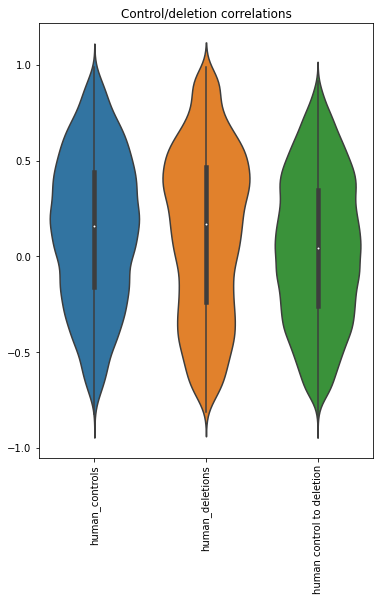

In [13]:
# Correlations between human controls, human deletion, and controls to deletion
corr_controls = corrs[(corrs['perturb1'] == 'human_control') & (corrs['perturb2'] == 'human_control')]
corr_deletion = corrs[(corrs['perturb1'] == 'human_deletion') & (corrs['perturb2'] == 'human_deletion')]
corr_control_to_deletion = corrs[(corrs['perturb1'] == 'human_deletion') & (corrs['perturb2'] == 'human_control') 
                                 | (corrs['perturb1'] == 'human_control') & (corrs['perturb2'] == 'human_deletion')]

to_df = [corr_controls['correlation'].tolist(), corr_deletion['correlation'].tolist(), corr_control_to_deletion['correlation'].tolist()]
corrs_controls_deletions = pd.DataFrame(to_df, index=['human_controls', 'human_deletions', 'human control to deletion']).T

# Plot the control/deletion correlations
fig, ax = plt.subplots(figsize=(6,8))
plt.title('Control/deletion correlations')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax = sns.violinplot(data=corrs_controls_deletions)

# Clusters

In [14]:
from sklearn.metrics.cluster import homogeneity_score
data_by_line = data_by_well.copy()
data_by_line['split'] = data_by_line.index.str.split('_')
data_by_line['perturb'] = [i[0] + '_' + i[1] + '_' + i[2] for i in data_by_line['split']]
data_by_line = data_by_line.groupby(by='perturb').median()

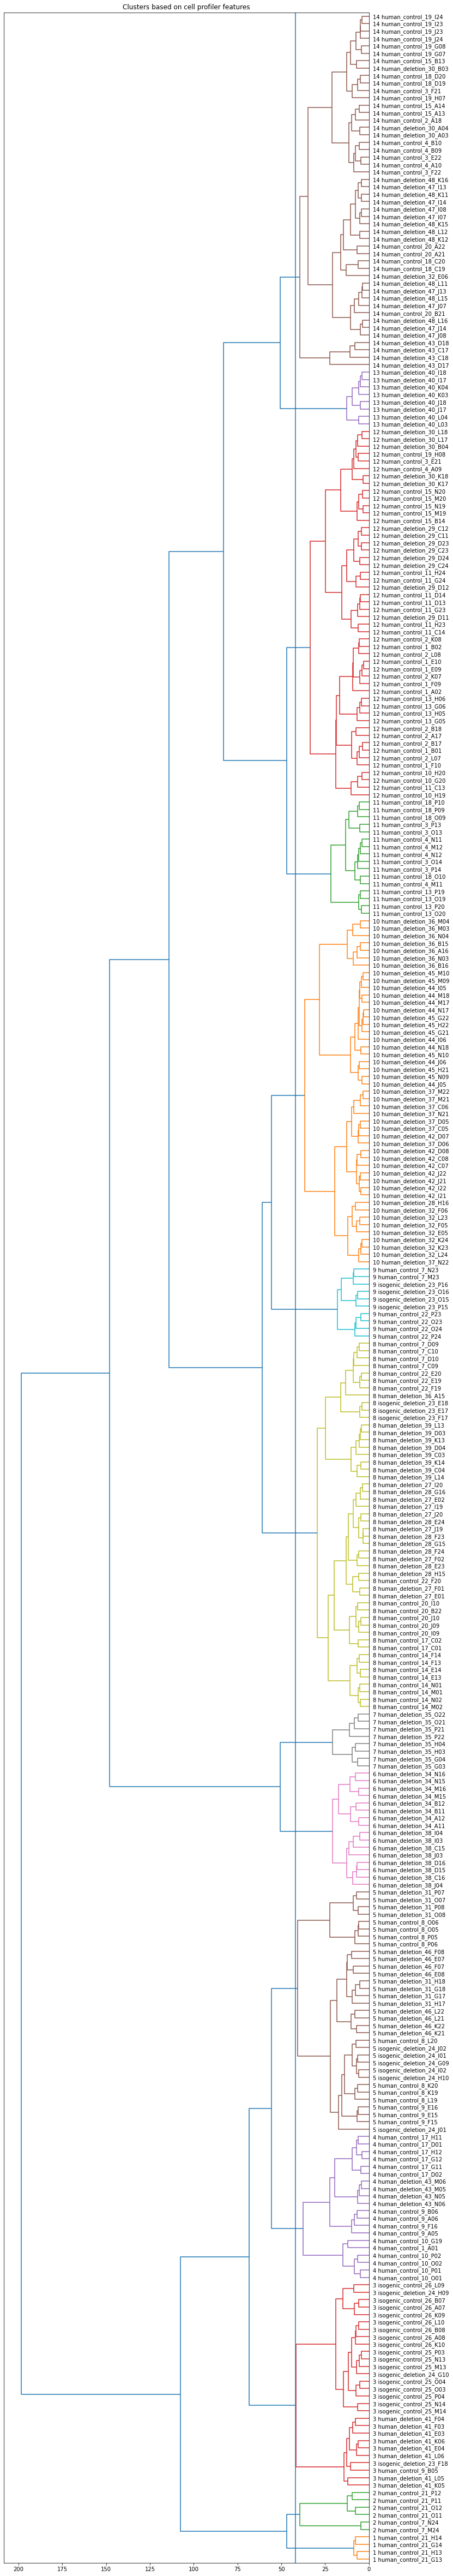

In [15]:
clusters = hierarchical_cluster(data_by_well, 42, show=True)

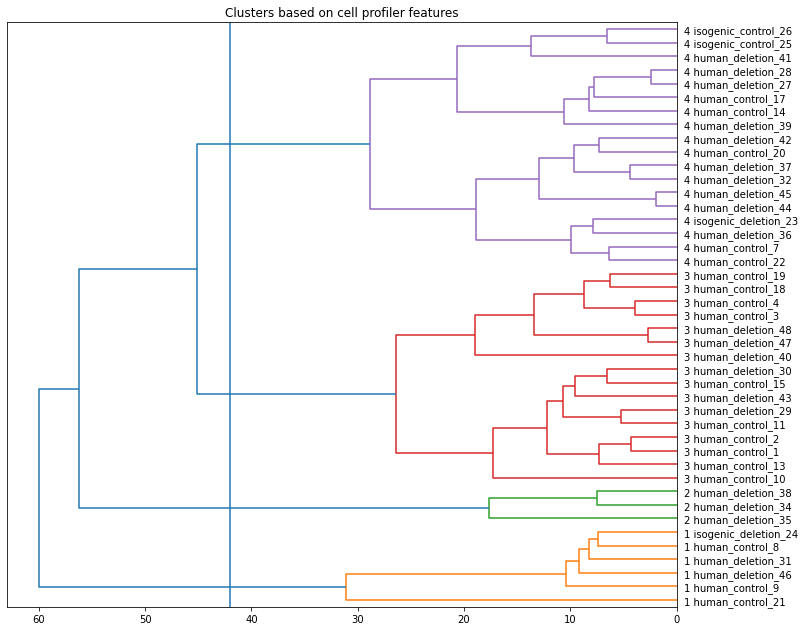

In [16]:
clusters1 = hierarchical_cluster(data_by_line, 42, show=True)

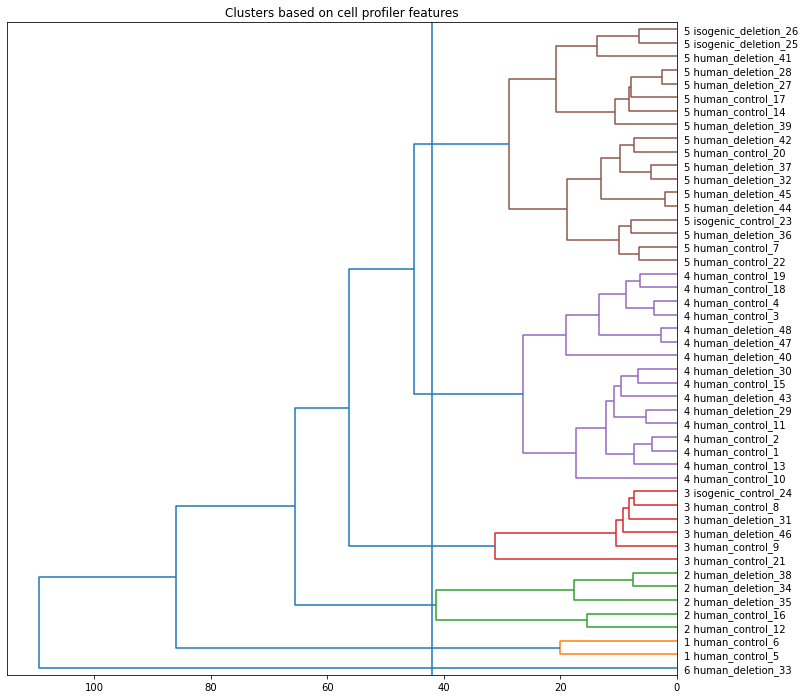

In [17]:
data_by_line_orig = data_by_well_orig.copy()
data_by_line_orig['split'] = data_by_line_orig.index.str.split('_')
data_by_line_orig['perturb'] = [i[0] + '_' + i[1] + '_' + i[2] for i in data_by_line_orig['split']]
data_by_line_orig = data_by_line_orig.groupby(by='perturb').median()
clusters_no_exclude = hierarchical_cluster(data_by_line_orig, 42, show=True)

In [18]:
# Compare homogeneity score between the clusters with and without excluding outlier wells
clusters1['perturb'] = clusters1.index.str.split('_').map(lambda x: x[0] + '_' + x[1])
print(homogeneity_score(clusters1['cluster_num'], clusters1['perturb']))
clusters_no_exclude['perturb'] = clusters_no_exclude.index.str.split('_').map(lambda x: x[0] + '_' + x[1])
print(homogeneity_score(clusters_no_exclude['cluster_num'], clusters_no_exclude['perturb']))

0.13210413879098246
0.10763644855222633


# PCA

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

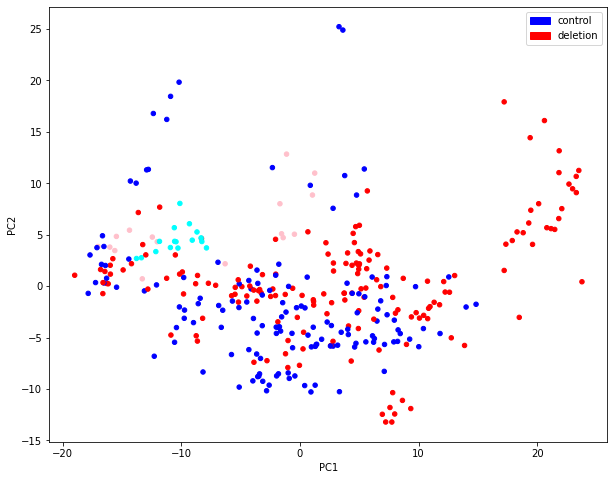

In [19]:
pca = PCA(n_components=2)
pca_fit = pca.fit(data_by_well)
pca_vals = pca_fit.transform(data_by_well)
pca_df = pd.DataFrame(pca_vals, columns=['PC1', 'PC2'], index=data_by_well.index)
idxs = [i.split('_')[0] + '_' + i.split('_')[1] for i in pca_df.index.tolist()]
idx2color = {'human_control': 'b', 'isogenic_control': 'cyan', 'human_deletion': 'r', 'isogenic_deletion': 'pink'}
colors = [idx2color[i] for i in idxs]
pca_df['color'] = colors

fig, ax = plt.subplots(figsize=(10,8))
p1 = mpatches.Patch(color='blue', label='control')
p2 = mpatches.Patch(color='red', label='deletion')
plt.legend(handles=[p1, p2])
pca_df.plot('PC1', 'PC2', kind='scatter', ax=ax, c='color')

In [20]:
pca_df[pca_df.index.str.contains('isogenic_del')]

,PC1,PC2,color
isogenic_deletion_23_E17,-1.411364,4.708204,pink
isogenic_deletion_23_E18,-1.546466,5.088849,pink
isogenic_deletion_23_F17,-0.462009,5.044413,pink
isogenic_deletion_23_F18,-6.305710,2.170245,pink
isogenic_deletion_24_G09,-16.022896,3.790680,pink
isogenic_deletion_24_G10,-12.441469,4.769292,pink
isogenic_deletion_24_H09,-12.029807,4.313957,pink
isogenic_deletion_24_H10,-14.366625,5.437552,pink
isogenic_deletion_24_I01,-15.603865,3.454627,pink
isogenic_deletion_24_I02,-15.471926,4.831151,pink


# Differentiating features

In [21]:
iso_ctrl = data_by_well[data_by_well.index.str.contains('isogenic_control')]
iso_del = data_by_well[data_by_well.index.str.contains('isogenic_deletion')]
human_ctrl = data_by_well[data_by_well.index.str.contains('human_control')]
human_del = data_by_well[data_by_well.index.str.contains('human_deletion')]

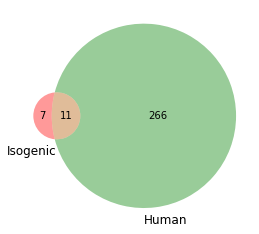

In [22]:
# Find features different between deletion and control in iso and human samples
iso_diff = ttest_2_df(iso_del, iso_ctrl, alpha=0.01, reject_only=True).sort_values(by='adj_p_value', ascending=True)
human_diff = ttest_2_df(human_del, human_ctrl, alpha=0.01, reject_only=True).sort_values(by='adj_p_value', ascending=True)

iso_only = [i for i in iso_diff.index.tolist() if i not in human_diff.index.tolist()]
human_only = [i for i in human_diff.index.tolist() if i not in iso_diff.index.tolist()]
shared = [i for i in iso_diff.index.tolist() if i in human_diff.index.tolist()]

venn2(subsets=(len(iso_only), len(human_only), len(shared)), set_labels=('Isogenic', 'Human'))

In [23]:
sorted(human_diff.index.tolist())

['Cells_AreaShape_Compactness',
 'Cells_AreaShape_Extent',
 'Cells_AreaShape_FormFactor',
 'Cells_AreaShape_MaximumRadius',
 'Cells_AreaShape_Zernike_2_0',
 'Cells_AreaShape_Zernike_2_2',
 'Cells_AreaShape_Zernike_4_4',
 'Cells_AreaShape_Zernike_5_1',
 'Cells_AreaShape_Zernike_5_3',
 'Cells_AreaShape_Zernike_6_2',
 'Cells_AreaShape_Zernike_7_1',
 'Cells_AreaShape_Zernike_7_3',
 'Cells_AreaShape_Zernike_8_2',
 'Cells_AreaShape_Zernike_8_4',
 'Cells_AreaShape_Zernike_8_6',
 'Cells_AreaShape_Zernike_9_1',
 'Cells_AreaShape_Zernike_9_3',
 'Cells_AreaShape_Zernike_9_5',
 'Cells_Correlation_Correlation_DNA_Mito',
 'Cells_Correlation_Correlation_Mito_AGP',
 'Cells_Correlation_Correlation_Mito_ER',
 'Cells_Correlation_K_AGP_Brightfield',
 'Cells_Correlation_K_Brightfield_ER',
 'Cells_Correlation_K_Brightfield_RNA',
 'Cells_Correlation_K_DNA_Brightfield',
 'Cells_Correlation_K_DNA_Mito',
 'Cells_Correlation_K_ER_Brightfield',
 'Cells_Correlation_K_Mito_Brightfield',
 'Cells_Correlation_K_RNA_Br

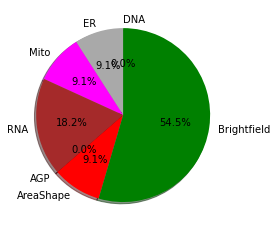

[0, 1, 1, 2, 0, 1, 6] 11


In [24]:
# Feature breakdown among features differentiating both isogenic and human
all_features = shared
dna_ch = [i for i in all_features if 'DNA' in i[-20:]]
er_ch = [i for i in all_features if 'ER' in i[-20:]]
mito_ch = [i for i in all_features if 'Mito' in i[-20:]]
rna_ch = [i for i in all_features if 'RNA' in i[-20:]]
agp_ch = [i for i in all_features if 'AGP' in i[-20:]]
areashape = [i for i in all_features if 'AreaShape' in i]
brightfield = [i for i in all_features if 'Brightfield' in i]
labels = ['DNA', 'ER', 'Mito', 'RNA', 'AGP', 'AreaShape', 'Brightfield']
sizes = [len(dna_ch), len(er_ch), len(mito_ch), len(rna_ch), len(agp_ch), len(areashape), len(brightfield)]

colors = ['b', 'darkgrey', 'magenta', 'brown', 'purple', 'r', 'g', 'orange']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, 
        shadow=True, startangle=90)
plt.show()

print(sizes,sum(sizes))

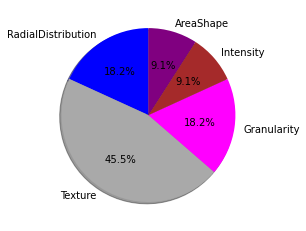

[2, 5, 2, 1, 1] 11


In [25]:
# Features by feature type for features differentiating both isogenic and human
all_features = shared
all_feature_types = [i.split('_')[1] for i in all_features]
all_feature_types = Counter(all_feature_types)
labels = []
sizes = []

fig1, ax1 = plt.subplots()
for x,y in all_feature_types.items():
    labels.append(x)
    sizes.append(y)
    
colors = ['b', 'darkgrey', 'magenta', 'brown', 'purple', 'r', 'g', 'orange']

ax1.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors,
        shadow=True, startangle=90)
plt.show()
print(sizes,sum(sizes))

In [26]:
# Look at difference between the control and deletion, for human and isogenic
human_ctrl = data_by_well[data_by_well.index.str.contains('human_control')]
iso_ctrl = data_by_well[data_by_well.index.str.contains('isogenic_control')]
human_del = data_by_well[data_by_well.index.str.contains('human_deletion')]
iso_del = data_by_well[data_by_well.index.str.contains('isogenic_deletion')]

human_del_ctrl_diff = human_del.median() - human_ctrl.median()
iso_del_ctrl_diff = iso_del.median() - iso_ctrl.median()

del_higher_both = []
del_lower_both = []
del_opposite_direction = []
for index, human_val in human_del_ctrl_diff.iteritems():
    iso_val = iso_del_ctrl_diff[index]
    if iso_val > 0 and human_val > 0:
        del_higher_both.append(index)
    elif iso_val < 0 and human_val < 0:
        del_lower_both.append(index)
    else:
        del_opposite_direction.append(index)

print('num features where deletion is higher in both iso and human: {}'.format(len(del_higher_both)))
print('num features where deletion is lower in both iso and human: {}'.format(len(del_lower_both)))
print('num features where deletion and control have opposite direction in iso and human: {}'.format(len(del_opposite_direction)))

num features where deletion is higher in both iso and human: 122
num features where deletion is lower in both iso and human: 198
num features where deletion and control have opposite direction in iso and human: 188


In [27]:
# Same as above, but look only at features which are significant in both isogenic and control
human_ctrl = data_by_well[data_by_well.index.str.contains('human_control')][shared]
iso_ctrl = data_by_well[data_by_well.index.str.contains('isogenic_control')][shared]
human_del = data_by_well[data_by_well.index.str.contains('human_deletion')][shared]
iso_del = data_by_well[data_by_well.index.str.contains('isogenic_deletion')][shared]

human_del_ctrl_diff = human_del.median() - human_ctrl.median()
iso_del_ctrl_diff = iso_del.median() - iso_ctrl.median()

del_higher_both = []
del_lower_both = []
del_opposite_direction = []
for index, human_val in human_del_ctrl_diff.iteritems():
    iso_val = iso_del_ctrl_diff[index]
    if iso_val > 0 and human_val > 0:
        del_higher_both.append(index)
    elif iso_val < 0 and human_val < 0:
        del_lower_both.append(index)
    else:
        del_opposite_direction.append(index)

print('num features where deletion is higher in both iso and human: {}'.format(len(del_higher_both)))
print('num features where deletion is lower in both iso and human: {}'.format(len(del_lower_both)))
print('num features where deletion and control have opposite direction in iso and human: {}'.format(len(del_opposite_direction)))

num features where deletion is higher in both iso and human: 3
num features where deletion is lower in both iso and human: 4
num features where deletion and control have opposite direction in iso and human: 4


In [28]:
data_by_line['group'] = data_by_line.index.str.split('_').map(lambda x: x[0] + '_' + x[1])
data_by_line.groupby(by='group').median()[shared]

,Cytoplasm_RadialDistribution_RadialCV_Brightfield_1of4,Cytoplasm_RadialDistribution_RadialCV_Brightfield_2of4,Cytoplasm_Texture_Correlation_Brightfield_20_01,Cells_Texture_Correlation_Brightfield_20_00,Cells_Granularity_1_Mito,Nuclei_Texture_Correlation_ER_10_00,Cells_Intensity_MinIntensity_Brightfield,Cytoplasm_Texture_Correlation_Brightfield_20_03,Cells_Texture_AngularSecondMoment_RNA_20_01,Cytoplasm_AreaShape_Compactness,Cells_Granularity_1_RNA
group,,,,,,,,,,,
human_control,-0.426989,-0.568967,0.035688,0.428614,-0.368505,0.366007,-0.046300,0.160993,-0.189952,-0.040402,-0.336009
human_deletion,0.072142,0.386685,-0.554354,-0.258221,-0.207425,0.257096,-0.185833,-0.404516,-0.062379,0.159819,-0.335184
isogenic_control,1.618542,1.032090,0.818531,-0.077975,-0.856640,0.265328,-0.520074,0.731644,-0.506581,-0.843188,-0.810441
isogenic_deletion,0.223896,-0.022968,0.179986,-0.669358,-0.664863,-0.115270,-0.255627,0.236274,-0.402638,-0.520795,-0.713195


In [29]:
print(len(del_opposite_direction) + len(del_higher_both) + len(del_lower_both))
[i for i in del_opposite_direction if 'Granu' in i or 'Tex' in i]
# del_higher_both
# del_lower_both

11


['Cells_Granularity_1_RNA']

In [30]:
def get_feature_type_count(list_of_features, categories):
    """
    Returns dictionary of counts to feature category
    Note that if the categories are channels instead of feature types, the features of 2 channels will be double counted.
    """
    counts = {}
    for cat in categories:
        features = [i for i in list_of_features if cat in i]
        counts[cat] = len(features)
    return counts

categories = ['Texture', 'Granularity', 'Intensity', 'RadialDistribution', 'AreaShape', 'Correlation']   
channels = ['DNA', 'ER', 'Mito', 'RNA', 'AGP', 'Brightfield', 'AreaShape']
# get_feature_type_count(del_opposite_direction, categories)    
# get_feature_type_count(del_opposite_direction, channels)    
# get_feature_type_count(del_higher_both, categories)    
get_feature_type_count(del_higher_both, channels) 
# get_feature_type_count(del_lower_both, categories)    
# get_feature_type_count(del_lower_both, channels) 
# get_feature_type_count(data_by_well.columns.tolist(), categories)  
# get_feature_type_count(data_by_well.columns.tolist(), channels)  

{'DNA': 0,
 'ER': 0,
 'Mito': 1,
 'RNA': 1,
 'AGP': 0,
 'Brightfield': 0,
 'AreaShape': 1}

# Differential feature analysis

In [31]:
sorted(del_higher_both) 
# del_lower_both 
# del_opposite_direction 

['Cells_Granularity_1_Mito',
 'Cells_Texture_AngularSecondMoment_RNA_20_01',
 'Cytoplasm_AreaShape_Compactness']

In [32]:
sorted(del_lower_both) 

['Cells_Texture_Correlation_Brightfield_20_00',
 'Cytoplasm_Texture_Correlation_Brightfield_20_01',
 'Cytoplasm_Texture_Correlation_Brightfield_20_03',
 'Nuclei_Texture_Correlation_ER_10_00']

In [33]:
sorted(del_opposite_direction)

['Cells_Granularity_1_RNA',
 'Cells_Intensity_MinIntensity_Brightfield',
 'Cytoplasm_RadialDistribution_RadialCV_Brightfield_1of4',
 'Cytoplasm_RadialDistribution_RadialCV_Brightfield_2of4']